m |   Z_model        Z_market       rel.err
 1 | 0.970873786408  0.970873786408  5.79e-14
 2 | 0.940768287831  0.940768287830  6.47e-13
 3 | 0.909831372872  0.909831372872  2.44e-16
 4 | 0.878210679243  0.878210679244  1.03e-12
 5 | 0.846052486576  0.846052486575  9.49e-13
 6 | 0.813500644307  0.813500644308  4.81e-13
 7 | 0.783338148918  0.783338148919  1.08e-12
 8 | 0.753567147541  0.753567147540  4.16e-13
 9 | 0.724229552024  0.724229552024  9.55e-13
10 | 0.695364373439  0.695364373439  3.09e-13

Payer swaption price: 4102.12


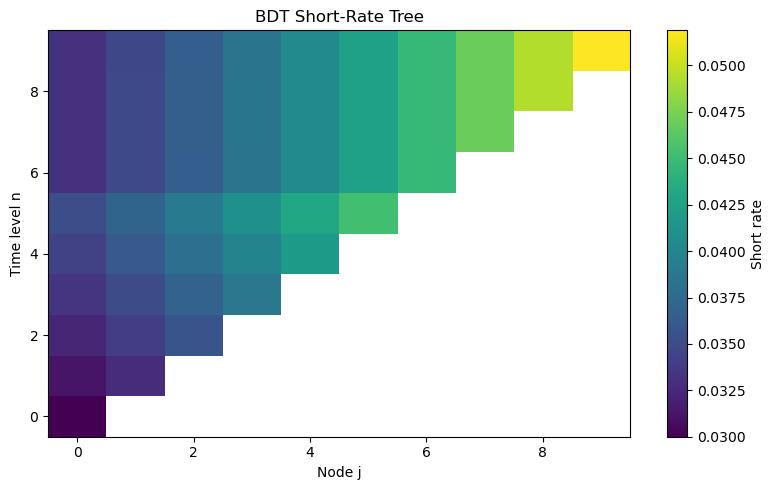

Max relative error on Z curve: 1.0750199838218822e-12
Inline test passed: model Z matches market Z within tolerance.


In [8]:
# BDT Swaption Pricer — 

import math
from typing import List
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Market inputs (edit here)
# -----------------------------
spot_rates = [0.030, 0.031, 0.032, 0.033, 0.034, 0.035, 0.0355, 0.036, 0.0365, 0.037]  # per-period compounding
notional = 1_000_000
fixed_rate = 0.039         # 3.9%
expiry = 3                 # swaption exercise at t=3
pay_times = list(range(4, 11))  # swap pays at t=4..10
b = 0.05                   # BDT log-vol parameter
p = 0.5                    # risk-neutral up probability (assumed 0.5)

# --------------------------------------------
# 2) Spot -> discount and simple utilities
# --------------------------------------------
def spot_to_discount(spot_rates: List[float]) -> List[float]:
    # Per-period compounding: Z(0,m) = 1 / (1 + s_m)^m for m=1..T
    return [1.0 / ((1.0 + s) ** (m + 1)) for m, s in enumerate(spot_rates)]

Z_market = spot_to_discount(spot_rates)
T = len(spot_rates)

# -----------------------------------------------------------
# 3) BDT model core: tree build, ZCB pricing, calibration
# -----------------------------------------------------------
def build_short_rate_tree(a_params: List[float], b: float, T: int) -> List[List[float]]:
    # r[n][j] applies from time n to n+1 at node j; n=0..T-1, j=0..n
    # BDT: r_{n,j} = a_{n+1} * exp(b * j)
    tree = []
    for n in range(T):
        a = a_params[n]
        level = [a * math.exp(b * j) for j in range(n + 1)]
        tree.append(level)
    return tree

def zcb_price_from_tree(r_tree: List[List[float]], m: int) -> float:
    # Price Z(0,m): pays 1 at time m (integer 1..T). Uses levels 0..m-1.
    values = np.ones(m + 1)
    for n in range(m - 1, -1, -1):
        new_vals = []
        for j in range(n + 1):
            cont = 0.5 * values[j] + 0.5 * values[j + 1]
            new_vals.append(cont / (1.0 + r_tree[n][j]))
        values = np.array(new_vals)
    return float(values[0])

def zcb_curve_from_tree(r_tree: List[List[float]], T: int) -> List[float]:
    return [zcb_price_from_tree(r_tree, m) for m in range(1, T + 1)]

def calibrate_bdt(spot_rates: List[float], b: float = 0.05, p: float = 0.5) -> List[List[float]]:
    # Calibrate a_i one-by-one so model Z(0,m) matches market Z(0,m).
    assert abs(p - 0.5) < 1e-12, "This implementation assumes p=0.5"
    T = len(spot_rates)
    Z_target = spot_to_discount(spot_rates)
    a_params: List[float] = []

    def model_price_for_level(a_val: float, level_len: int) -> float:
        # Trial 'a' up to this level; pad with a stable placeholder after for tree shape
        trial = a_params + [a_val] + [max(1e-6, a_params[-1] if a_params else 0.01)] * (T - level_len)
        r_tree_trial = build_short_rate_tree(trial, b, T)
        return zcb_price_from_tree(r_tree_trial, level_len)

    for m in range(1, T + 1):
        target = Z_target[m - 1]
        low, high = 1e-6, 1.0

        f_low = model_price_for_level(low, m) - target
        f_high = model_price_for_level(high, m) - target
        tries = 0
        while f_low * f_high > 0 and tries < 80:
            high *= 2.0
            f_high = model_price_for_level(high, m) - target
            tries += 1

        # Bisection
        for _ in range(200):
            mid = 0.5 * (low + high)
            f_mid = model_price_for_level(mid, m) - target
            if abs(f_mid) < 1e-12:
                a_params.append(mid)
                break
            if f_low * f_mid < 0:
                high = mid
                f_high = f_mid
            else:
                low = mid
                f_low = f_mid
        else:
            a_params.append(0.5 * (low + high))

    return build_short_rate_tree(a_params, b, T)

# ------------------------------------------------------
# 4) Node discount factor and swap value at a node
# ------------------------------------------------------
def node_discount_factor(r_tree: List[List[float]], i: int, j: int, m: int) -> float:
    # Discount factor P(i,m) from node (time i, node j) to time m (> i).
    assert m > i, "m must be greater than i"
    values = np.ones(m - i + 1)  # nodes j..j+(m-i)
    for n in range(m - 1, i - 1, -1):
        new_vals = []
        for k in range(n - i + 1):
            cont = 0.5 * values[k] + 0.5 * values[k + 1]
            new_vals.append(cont / (1.0 + r_tree[n][j + k]))
        values = np.array(new_vals)
    return float(values[0])

def payer_swap_value_node(r_tree: List[List[float]], notional: float, fixed_rate: float,
                          i: int, j: int, pay_times: List[int]) -> float:
    # Value at node (i,j) of a payer swap (receive float, pay fixed).
    annuity = 0.0
    for t_pay in pay_times:
        if t_pay <= i:
            continue
        annuity += node_discount_factor(r_tree, i, j, t_pay)
    P_i_T = node_discount_factor(r_tree, i, j, pay_times[-1])
    float_leg = 1.0 - P_i_T
    return notional * (float_leg - fixed_rate * annuity)

# ---------------------------------------------
# 5) Calibrate tree and verify curve fit
# ---------------------------------------------
r_tree = calibrate_bdt(spot_rates, b=b, p=p)
Z_model = zcb_curve_from_tree(r_tree, T)

print("m |   Z_model        Z_market       rel.err")
for m, (zm, zt) in enumerate(zip(Z_model, Z_market), start=1):
    print(f"{m:2d} | {zm:.12f}  {zt:.12f}  {abs(zm-zt)/zt:.2e}")

# ---------------------------------------------
# 6) Price the payer swaption (expiry t=3)
# ---------------------------------------------
payoffs = []
for j in range(expiry + 1):
    v = payer_swap_value_node(r_tree, notional, fixed_rate, expiry, j, pay_times)
    payoffs.append(max(v, 0.0))

values = np.array(payoffs)
for n in range(expiry - 1, -1, -1):
    new_vals = []
    for j in range(n + 1):
        cont = 0.5 * values[j] + 0.5 * values[j + 1]
        new_vals.append(cont / (1.0 + r_tree[n][j]))
    values = np.array(new_vals)

swaption_price = float(values[0])
print(f"\nPayer swaption price: {swaption_price:.2f}")

# ---------------------------------------------
# 7) Plot the calibrated short-rate tree
# ---------------------------------------------
def plot_short_rate_tree(r_tree, title="BDT Short-Rate Tree"):
    T = len(r_tree)
    maxw = T
    mat = np.full((T, maxw), np.nan)
    for n, level in enumerate(r_tree):
        mat[n, :len(level)] = level
    fig, ax = plt.subplots(figsize=(8, 5))
    img = ax.imshow(mat, aspect="auto", origin="lower")
    ax.set_xlabel("Node j")
    ax.set_ylabel("Time level n")
    ax.set_title(title)
    fig.colorbar(img, ax=ax, label="Short rate")
    plt.tight_layout()
    return fig, ax

fig, ax = plot_short_rate_tree(r_tree)
plt.show()

# ---------------------------------------------
# 8) Inline test: curve fit
# ---------------------------------------------
rel_err = np.max(np.abs((np.array(Z_model) - np.array(Z_market)) / np.array(Z_market)))
print("Max relative error on Z curve:", rel_err)
assert rel_err < 1e-8, f"Curve mismatch too large: {rel_err}"
print("Inline test passed: model Z matches market Z within tolerance.")


In [9]:
# ---------------------------------------------
# Receiver Swaption (expiry t=3)
# ---------------------------------------------

# Receiver swap: opposite sign of payer swap
def receiver_swap_value_node(r_tree, notional, fixed_rate, i, j, pay_times):
    return -payer_swap_value_node(r_tree, notional, fixed_rate, i, j, pay_times)

# Payoff at expiry nodes
receiver_payoffs = []
for j in range(expiry + 1):
    v = receiver_swap_value_node(r_tree, notional, fixed_rate, expiry, j, pay_times)
    receiver_payoffs.append(max(v, 0.0))

# Backward induction to t=0
values = np.array(receiver_payoffs)
for n in range(expiry - 1, -1, -1):
    new_vals = []
    for j in range(n + 1):
        cont = 0.5 * values[j] + 0.5 * values[j + 1]
        new_vals.append(cont / (1.0 + r_tree[n][j]))
    values = np.array(new_vals)

receiver_swaption_price = float(values[0])
print(f"Receiver swaption price: {receiver_swaption_price:.2f}")


Receiver swaption price: 3911.38


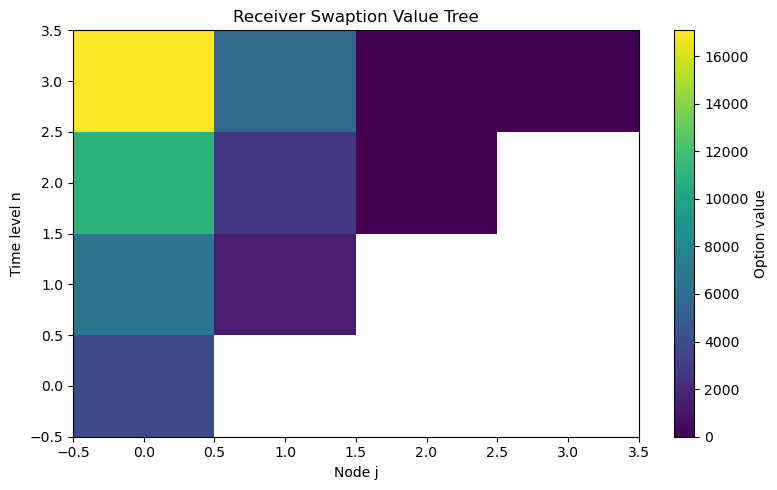

In [10]:
# ---------------------------------------------
# Plot Receiver Swaption Value Tree (like short-rate heatmap)
# ---------------------------------------------

def plot_option_value_tree(r_tree, expiry, payoffs, title="Option Value Tree"):
    """
    Build a matrix of option values at each node (like the short-rate tree plot).
    Shows payoffs at expiry, then backward induction values.
    """
    T = expiry + 1
    # Initialize matrix with NaN
    mat = np.full((T, T), np.nan)

    # Store values at expiry
    values = np.array(payoffs, dtype=float)
    mat[expiry, :len(values)] = values

    # Backward induction
    for n in range(expiry - 1, -1, -1):
        new_vals = []
        for j in range(n + 1):
            cont = 0.5 * values[j] + 0.5 * values[j + 1]
            new_vals.append(cont / (1.0 + r_tree[n][j]))
        values = np.array(new_vals)
        mat[n, :len(values)] = values

    # Plot like heatmap
    fig, ax = plt.subplots(figsize=(8, 5))
    img = ax.imshow(mat, aspect="auto", origin="lower")
    ax.set_xlabel("Node j")
    ax.set_ylabel("Time level n")
    ax.set_title(title)
    fig.colorbar(img, ax=ax, label="Option value")
    plt.tight_layout()
    return fig, ax, mat

# Plot for receiver swaption
fig, ax, receiver_value_matrix = plot_option_value_tree(
    r_tree, expiry, receiver_payoffs, title="Receiver Swaption Value Tree"
)
plt.show()


1. Side-by-side visualization

Put payer vs receiver swaption value trees next to each other with the same color scale.

Payer swaption price:    4,102.12
Receiver swaption price: 3,911.38


C:\Users\HP\AppData\Local\Temp\ipykernel_11932\531704765.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


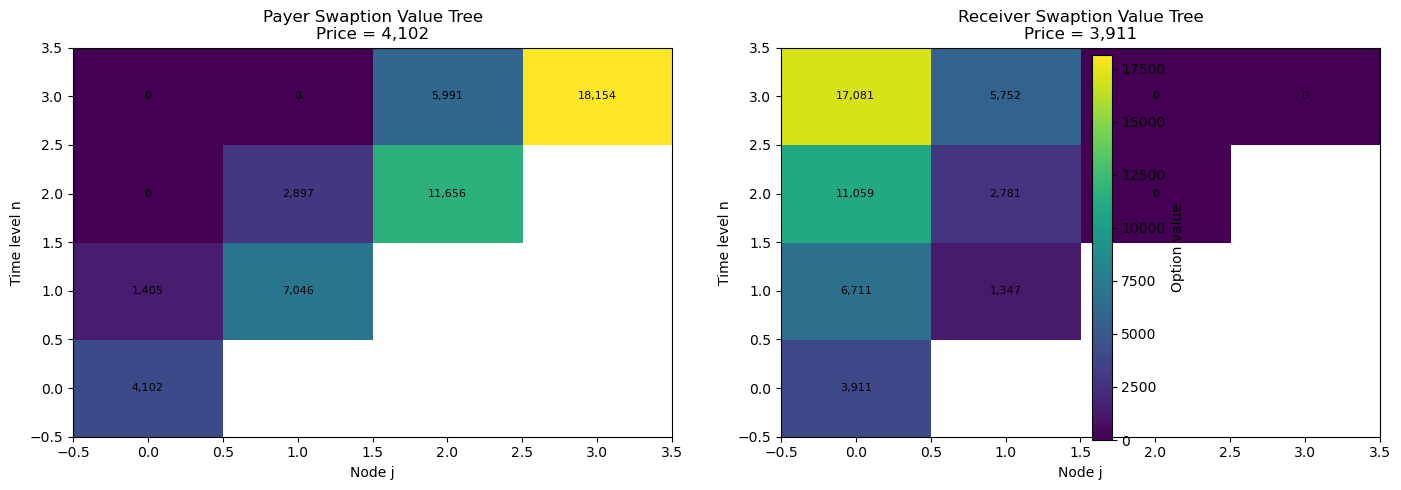

In [11]:
# === Side-by-side heatmaps for Payer vs Receiver swaptions ===
# Requires: r_tree, expiry, pay_times, notional, fixed_rate
import numpy as np
import matplotlib.pyplot as plt

# --- helpers (safe to re-run even if previously defined) ---
def node_discount_factor(r_tree, i, j, m):
    assert m > i
    values = np.ones(m - i + 1)
    for n in range(m - 1, i - 1, -1):
        new_vals = []
        for k in range(n - i + 1):
            cont = 0.5 * values[k] + 0.5 * values[k + 1]
            new_vals.append(cont / (1.0 + r_tree[n][j + k]))
        values = np.array(new_vals)
    return float(values[0])

def payer_swap_value_node(r_tree, notional, fixed_rate, i, j, pay_times):
    annuity = 0.0
    for t_pay in pay_times:
        if t_pay > i:
            annuity += node_discount_factor(r_tree, i, j, t_pay)
    P_i_T = node_discount_factor(r_tree, i, j, pay_times[-1])
    float_leg = 1.0 - P_i_T
    return notional * (float_leg - fixed_rate * annuity)

def build_option_value_matrix(r_tree, expiry, payoffs):
    """Return matrix [time n, node j] with option values at each node."""
    Tloc = expiry + 1
    mat = np.full((Tloc, Tloc), np.nan)
    # expiry payoffs
    values = np.array(payoffs, dtype=float)
    mat[expiry, :len(values)] = values
    # backward induction
    for n in range(expiry - 1, -1, -1):
        new_vals = []
        for j in range(n + 1):
            cont = 0.5 * values[j] + 0.5 * values[j + 1]
            new_vals.append(cont / (1.0 + r_tree[n][j]))
        values = np.array(new_vals)
        mat[n, :len(values)] = values
    return mat

def annotate(ax, mat):
    for n in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            v = mat[n, j]
            if not np.isnan(v):
                ax.text(j, n, f"{v:,.0f}", ha="center", va="center", fontsize=8)

# --- build payoffs at expiry (t = expiry) ---
payer_payoffs = [max(payer_swap_value_node(r_tree, notional, fixed_rate, expiry, j, pay_times), 0.0)
                 for j in range(expiry + 1)]
receiver_payoffs = [max(-payer_swap_value_node(r_tree, notional, fixed_rate, expiry, j, pay_times), 0.0)
                    for j in range(expiry + 1)]

# --- build value matrices (includes back-induction to t=0) ---
payer_mat = build_option_value_matrix(r_tree, expiry, payer_payoffs)
receiver_mat = build_option_value_matrix(r_tree, expiry, receiver_payoffs)

# Prices are the top-left entries (time 0, node 0)
payer_price = float(payer_mat[0,0])
receiver_price = float(receiver_mat[0,0])
print(f"Payer swaption price:    {payer_price:,.2f}")
print(f"Receiver swaption price: {receiver_price:,.2f}")

# --- side-by-side heatmaps with shared color scale and annotations ---
vmin = np.nanmin([np.nanmin(payer_mat), np.nanmin(receiver_mat)])
vmax = np.nanmax([np.nanmax(payer_mat), np.nanmax(receiver_mat)])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = axes[0].imshow(payer_mat, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
axes[0].set_title(f"Payer Swaption Value Tree\nPrice = {payer_price:,.0f}")
axes[0].set_xlabel("Node j"); axes[0].set_ylabel("Time level n")
annotate(axes[0], payer_mat)

im1 = axes[1].imshow(receiver_mat, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
axes[1].set_title(f"Receiver Swaption Value Tree\nPrice = {receiver_price:,.0f}")
axes[1].set_xlabel("Node j"); axes[1].set_ylabel("Time level n")
annotate(axes[1], receiver_mat)

fig.colorbar(im1, ax=axes.ravel().tolist(), label="Option value")
plt.tight_layout()
plt.show()
